<a href="https://colab.research.google.com/github/Hasim-dev/Style-Transfer/blob/master/VGG16_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# gerekli kütüphaneler
# required libraries

%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import PIL.ImageOps
import cv2

In [0]:
# .features ile sadece feature extraction kısmını aldık.
vgg = models.vgg19(pretrained=True).features 

# vgg modelinin ağırlıklarının back propagation ile değişmemesini sağladık.
for param in vgg.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:21<00:00, 26.6MB/s]


In [0]:
%%capture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device) # gpu kullan

In [0]:
# path'tan image'i çekmek için fonksiyon
def load_image(img_path, max_size=400, shape=None): # max_size: image için threshold'umuz
  image = Image.open(img_path).convert('RGB')
  # vgg modeline sokacağımız imagein boyutunun kontrol edilmesi gerekiyor.

  # sadece kısa kenarı 400'e limitliyoruz.
  # .size width, height döndürür. max(width, height) max_size'dan büyük ise
  if max(image.size) > max_size: 
    size = max_size # image boyutu thresholda düşürüldü.
  else: # max(width, height) max_size'dan küçük ise
    size = max(image.size) # image boyutu aynı bırakıldı.

  in_transform = transforms.Compose([
                                        # image'in kısa kenarı "size" kadar yapıldı
                                        # kısa kenar en fazla 400 olabilir.
                                        # uzun kenar hâlâ 400'den uzun olabilir.
                                        # bu yöntem, işlem gücünden kazanmak için uygulandı.
                                        # Resize(), aspect ratio'yu korur.
                                        # uzun kenar da kısa kenarla aynı oranda değişecek.
                                        transforms.Resize(size),
                                        # image tensora çevrildi. 
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5),
                                                             (0.5, 0.5, 0.5))
                                        ])
  image = in_transform(image).unsqueeze(0)
  return image

In [0]:
# content = load_image("http://famouswonders.com/wp-content/uploads/2009/04/new-york-skyline-at-night.jpg").to(device)
content = load_image("unnamed.jpg").to(device)
style = load_image("StarryNight.jpg").to(device)
# style image boyutunu content image ile aynı yaptık. shape=content.shape[-2:]. [-2:] sondan iki değeri al.

In [0]:
# image'i görüntülemek için fonksiyon
# Tensor image'leri plot etmek için tekrar numpy arraye dönüştürmemiz gerekiyor.
def im_convert(tensor):
  
  # Tensor; color channel, width, channel sütunlarından oluşur. (1, 28, 28)
  image = tensor.cpu().clone().detach().numpy()

  image = image.squeeze()
  
  # (1, 28, 28) oldu
  image = image.transpose(1, 2, 0) 
  #print(image.shape)
  
  # Denormalization
  image = image*np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
  
  # image'i normalize edince pikseller -1, 1 arasında oldu.  0, 1 arasında yapmak için.
  image = image.clip(0, 1)
  
  return image

(-0.5, 615.5, 399.5, -0.5)

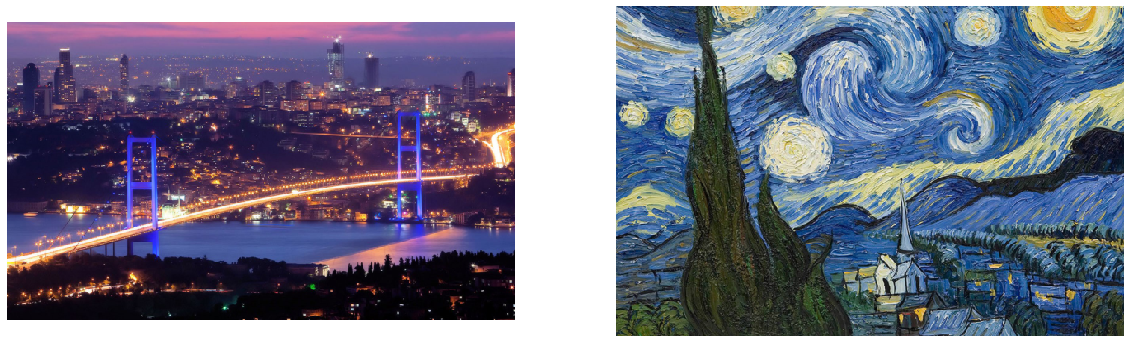

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [0]:
# image:feature çıkarmak istediğimiz image, model: feature çıkarmak için kullanılacak model
def get_features(image, model):
  # layers: dict object olacak. feature extr. için kullanacağımız layerleri içeriyor.
  # sadece (21): Conv2d content için, 
  # diğer 5 layer style extraction için kullanılacak. çünkü style yaratma daha kompleks bir işlem.
  # bir sürü layer'dan style feature çıkarmak en iyi sonucu verir. daha fazla feature, daha fazla style aktarımı
  layers = {'0' : 'conv1_1',
            '5' : 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2', # content extraction için kullanılacak olan layer. bu işlem için sadece 1 layer yeterli.
            '28': 'conv5_1'}
  features = {} # çıkarılan feature'leri tutmak için dict.

  for name, layer in model._modules.items():
    image = layer(image)

    if name in layers:
      features[layers[name]] = image
  return features


In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [0]:
# style feature'ları ekstra bir preprocess işlemine ihtiyaç duyuyor.
# daha etkili style transfer için gram matrix kullanılıyor.
# gram matrix kullanarak image'dan alınan content ve style bilgilerinden sadece style'ı alıyoruz.
# feature'lara gram matrix uygulayarak datayla ilgili texture üretiyoruz.(texture synthesis)
# gram = V^T*V

In [0]:
def gram_matrix(tensor):
  _, d, h, w = tensor.size() #b:batch size(ihmal edildi), d:image depth, h:height, w:width
  tensor = tensor.view(d, h*w) # tensor datasının tutulacağı 2d tensor elde edildi.
  gram = torch.mm(tensor, tensor.t()) # gram matrix için tensor*tensor^T çarpımı.
  return gram

In [0]:
# style_features'a layeri ver, dönen feature'ı gram_matrix'e sok.
# style_grams(dict) içine çıkarılan feature'ların gram matrix'lerini koyduk. texture için gerekli.
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [0]:
# image style için 5 layer seçmiştik.
# modelin başındaki layer'lar style aktarımı için daha etkili.
# sonraki layerlar style'ı çeşitlendiriyor.
# başlardaki layer'lara öncelik vermek için ağırlık atayabiliriz.

In [0]:
style_weights =  {'conv1_1': 1., 
                  'conv2_1': .75, 
                  'conv3_1': .5, 
                  'conv4_1': .75, 
                  'conv5_1': .5,}
# style image ve content image arasındaki oranı belirlememiz gerekiyor.
# alpha:content image weight, beta:style image weight
content_weight = 1 # alpha
style_weight = 1e2 # beta - bu değerle oynanabilir. 1e5, 1e4... gibi

In [0]:
# target image content image'ın klonu olarak başlıyor.
# Her iterasyonda daha fazla style aktarılıyor.
target = content.clone().requires_grad_(True).to(device)

In [0]:
# her 300 iterasyonda görüntü güncellenerek görüntülenecek. bu değişebilir.
show_every = 300 # (300'dü)

# optimizer seçildi. target(image) her iterasyonda optim. edilecek.
optimizer = optim.Adam([target], lr=0.003)

# optimizasyon adım sayısı bu değişebilir.
steps = 2400 # (2100'di)

# train'den sonra data görselleştirme

# target image boyutunu tut
height, width, channels = im_convert(target).shape

# training boyunca target image'i tutacak array
# daha sonra bu array videoya dönüştürülebilir.
image_array = np.empty(shape=(show_every, height, width, channels))

# frame sayısı
capture_frame = steps/show_every

# counter, bulunduğumuz array index'ini tutacak. başlangıç=0
counter = 0

Total loss:  221.4360809326172
Iteration:  300


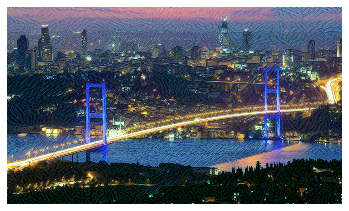

Total loss:  86.3594970703125
Iteration:  600


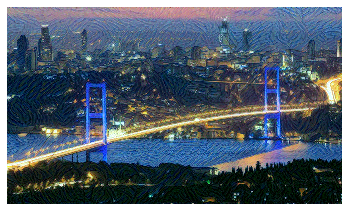

Total loss:  58.5750846862793
Iteration:  900


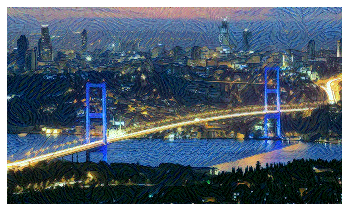

Total loss:  47.608245849609375
Iteration:  1200


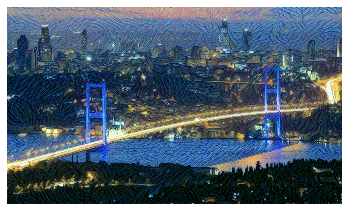

Total loss:  41.16682815551758
Iteration:  1500


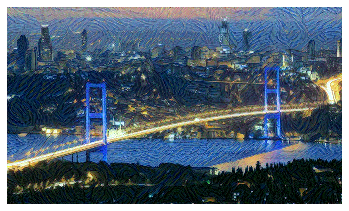

Total loss:  36.68711471557617
Iteration:  1800


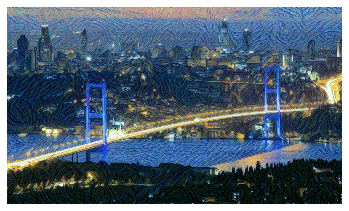

Total loss:  33.28139877319336
Iteration:  2100


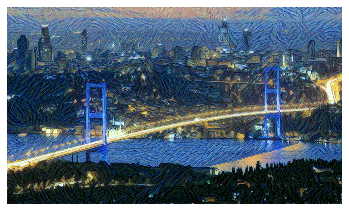

Total loss:  30.545032501220703
Iteration:  2400


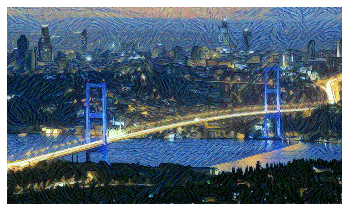

In [0]:
# Optimizasyon adımları

for ii in range(1, steps+1):
  target_features = get_features(target, vgg) # target image için feature'ları toplama
  
  # conv4_2 content feature extr. için kullanılmıştı.
  # mse
  content_loss = torch.mean((target_features['conv4_2']- content_features['conv4_2'])**2)
  
  # 5 style katmanının ağırlıklı ortalaması ile hesaplanır
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram- style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  
  total_loss = content_loss * content_weight + style_loss * style_weight

  # optimizer resetlendi.
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis('off')
    plt.show()

  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1

(-0.5, 679.5, 399.5, -0.5)

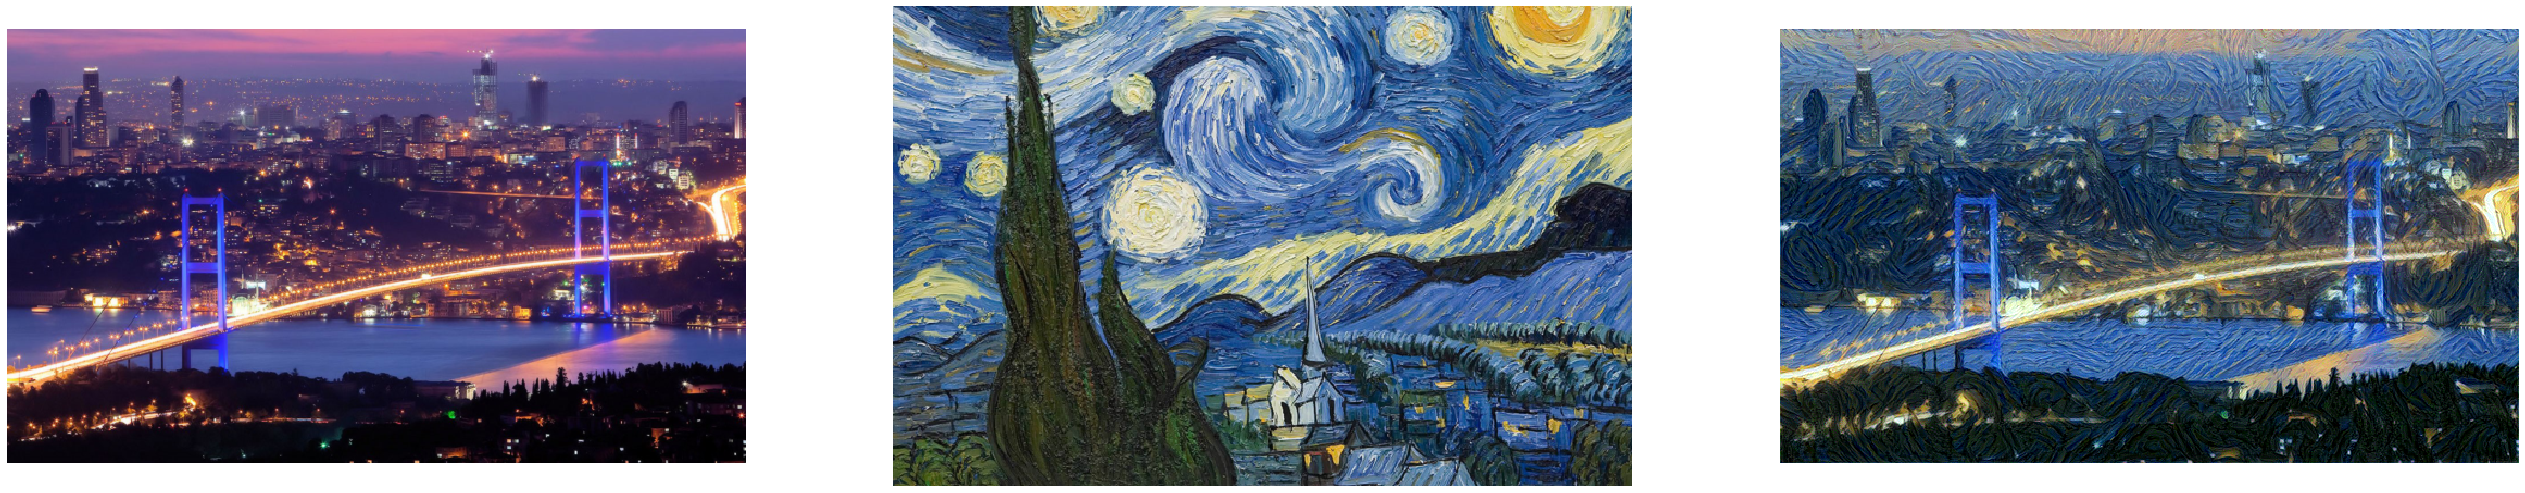

In [0]:
# ender 1e5, 300, 2100
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(45,15))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [0]:
import cv2 
 
frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('ender1e5-2100.mp4', cv2.VideoWriter_fourcc(*'XVID'), 40, (frame_width, frame_height))
 
for i in range(0, show_every):
  img = image_array[i]
  img = img*255 # denormalize et
  img = np.array(img, dtype = np.uint8) # 8-bit int type video için gerekiyor.
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)
 
vid.release()

In [0]:
from google.colab import files
files.download('ender1e5-2100.mp4')